# Raw Extraction of required data 

Note that the raw extraction of required data takes a very long time, the import of pre-computed values is avaliable at the Plotting Code section.

In [64]:
import pandas as pd
import numpy as np
import tqdm
import csv
from datetime import datetime

In [65]:
# Defining the list indexes
indexes = {
    'Malware':0,
    'Phishing':1,
    'Exploits':2,
    'Fraudlent Services':3,
    'Unwanted Programs':4,
    'Spammers':5,
    'Unlabelled':6,
}

attack_map = ['Malware', 'Phishing', 'Exploits', 'Fraudlent Services',
            'Unwanted Programs', 'Spammers', 'Unlabelled']

In [66]:
# Convert date fields back into a python date object
date_calculation_cache = {}
def make_date(day, month, year, iso=True):
    date = '%s-%s-%s' % (day, month, year)
    # Check cache before recomputation
    if date not in date_calculation_cache:
        if iso:
            cal = datetime.strptime(date, "%d-%m-%Y").isocalendar()
        else:
            cal = datetime.strptime(date, "%d-%m-%Y")
        date_calculation_cache[date] = cal
    else:
        cal = date_calculation_cache[date]
    return cal

In [75]:
# Track inter-host relationships
ip_in_asn = {}
for attk in indexes:
    ip_in_asn[attk] = {}

In [ ]:
# Initialise a dictionary to hold all our data.
# We will later convert this into a pandas dataframe for easy processing
ip_attacks = {}

for attack in indexes:
    print(attack)
    files = []
    if attack == 'Unlabelled':
        # There are 23 files containing Unlabelled reports
        for i in range(23):
            files.append(('./../../Datastore/%s_reports_%s.csv'%(attack,i), attack, i))
    else:
        #continue
        files.append(('./../../Datastore/%s_reports.csv'%attack, attack, None))
    #########################
    
    # Process the files
    for file_name, a, file_num in files:
        print(file_name)
        with open(file_name) as data_file:
            filereader = csv.reader(data_file)
            if attack == 'Unlabelled':
                activity_relabel = pd.read_csv('./../../Unlabelled_predictions/%s_predictions_%s.csv'%(a, file_num),
                                               index_col=[0], header=None)
                activity_relabel = activity_relabel.transpose().values[0]
            for n, report in enumerate(tqdm.tqdm(filereader)):
                try:
                    # Unpack Row information
                    splits = report[0:9]

                    day = splits[5]
                    month = splits[6]
                    year = splits[7]
                    datasource = splits[8]        
                    org = splits[3]
                    asn = splits[2]
                    cc = splits[1]
                    ip = splits[0]
                    
                    # Compute week bins
                    cal = make_date(day, month, year, iso=False)
                    year_num, week_num, weekday_num = cal.isocalendar()

                    # Invalid Timestamp, likely 0.
                    if year_num == 1970:
                        continue
                    week = (year_num-1970)*52 + week_num

                except Exception, e: 
                    print(str(e))

                if ip is None or ip == '':
                    print("Skipping invalid IP: %s" % ip)
                    continue

                # Relabelling unlabelled reports
                if (attack == 'Unlabelled'):
                    attack_label = attack_map[activity_relabel[n]]
                else:
                    attack_label = attack

                # Initialise the holder
                key = asn
                if key not in ip_attacks:
                    ip_attacks[key] = [0] * 7

                # Increment the relevant list position
                i = indexes[attack_label]
                ip_attacks[key][i] += 1

                if asn not in ip_in_asn[attack_label]:
                    ip_in_asn[attack_label][asn] = set([])
                ip_in_asn[attack_label][asn].add(ip)
                
print('Finished')

In [77]:
# save inter-host relationships
import cPickle
cPickle.dump(ip_in_asn, open('ip_in_asn.pickle', 'wb'))

# Generate DataFrame

In [10]:
################################
# ASN Filter
import pandas as pd
# Turn into a pandas array
ip_attack_frame = pd.DataFrame.from_dict(ip_attacks, orient='index')
# relabel the colum names
ip_attack_frame.columns = attack_map
# Drop invalid ASs
ip_attack_frame.drop('-1',inplace=True)

In [11]:
# Save the DataFrame
ip_attack_frame.to_csv('asn_attack_frame.csv')

# Plotting code

## Import precomputed data

In [13]:
import pandas as pd
ip_attack_frame = pd.read_csv('asn_attack_frame.csv', index_col=0)

## Top offending ASs

In [14]:
if 'Totals' in ip_attack_frame:
    ip_attack_frame.drop('Totals', axis=1,inplace=True)

ip_attack_frame['Totals'] = ip_attack_frame.transpose().sum()

ip_attack_frame[['Totals','Malware','Phishing','Spammers',
                 'Unwanted Programs','Exploits','Fraudlent Services']
               ].sort_values('Totals', ascending=False).head(10)

,Totals,Malware,Phishing,Spammers,Unwanted Programs,Exploits,Fraudlent Services
16509,25780070,24730443,463396,45,323347,20106,242733
20940,4540203,4083724,272612,0,152676,1076,30115
2914,2179430,2074612,87713,0,16533,406,166
35994,1666782,1567854,81695,0,15555,319,1359
209,1426533,1300545,114922,54,10032,518,462
3257,1138253,1045529,84834,0,7621,193,76
14618,1053876,824285,66336,107,104836,30114,28198
16276,1041795,980549,18289,104,4851,18366,19636
701,639313,613051,23407,0,2490,81,284
4134,625087,478846,141866,31,489,1427,2428


## Unique AS Summary

In [15]:
a = ip_attack_frame.drop('Totals',axis=1)
a = a.transpose().sum()
a = a[a > 0]
labelled_len = len(a)
full_len = len(ip_attack_frame)

print '%20s:%10s: %7s: %6s'%('Attack','Unique','Ratio','%')

# Attack Label
for attk in indexes:
    if attk == 'Unlabelled':
        continue
    attk_len = len(ip_attack_frame[attk][ip_attack_frame[attk]>0])
    ratio = 1.0*attk_len/labelled_len
    percent = ratio*100.0
    print '%20s:%10s: %0.5f: %6.2f'%(attk,attk_len,ratio,percent)

# Labelled
ratio = 1.0*labelled_len/full_len
percent = ratio*100.0
print '%20s:%10s: %0.5f:% 6.2f'%('Labelled',labelled_len,ratio,percent)
    
print '%20s:%10s: %0.5f:% 6.2f'%('Totals',full_len,1.0,100.0)

              Attack:    Unique:   Ratio:      %
            Spammers:       561: 0.04332:   4.33
             Malware:     11435: 0.88301:  88.30
            Exploits:      2966: 0.22903:  22.90
            Phishing:      4402: 0.33992:  33.99
  Fraudlent Services:      3264: 0.25205:  25.20
   Unwanted Programs:      2200: 0.16988:  16.99
            Labelled:     12950: 1.00000: 100.00
              Totals:     12950: 1.00000: 100.00


## Graph Plotting Parameters

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import dateutil.relativedelta

plot_properties_indexes = {
    'Unwanted Programs':{'color':'b', 'linestyle':'-', 'label':'PUP',
                         'marker':'s', 'hatch':'//'},

    'Fraudlent Services':{'color':'y', 'linestyle':'-', 'label':'Fraud. Serv.',
                          'marker':'*','hatch':'\\'},

    'Malware':{'color':'r', 'linestyle':'-', 'label':'Malware',
               'marker':'x', 'hatch':'x'},

    'Exploits':{'color':'m', 'linestyle':'-', 'label':'Exploits',
                'marker':'+', 'hatch':'+'},

    'Phishing':{'color':'g', 'linestyle':'-', 'label':'Phishing',
                'marker':'^', 'hatch':'|'},

    'Spammers':{'color':'c', 'linestyle':'-', 'label':'Spammers',
                'marker':'D', 'hatch':'\\\\'},

    'Unlabelled':{'color':'w', 'linestyle':'-', 'label':'Unlabelled',
                  'marker':'T', 'hatch':'///'},

    'Totals':{'color':'k', 'linestyle':'-', 'label':'Total',
              'marker':'o', 'hatch':''}
}

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cPickle

def cdf(data, m,n,s,lstring):

    data_size=len(data)

    # Set bins edges
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)
    #new_bins = [bins[i] for i in range(len(bins)) if (i/5)%5==0]
    #print len(bins)
    #print len(new_bins)
    

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    #print counts
    #print bin_edges
    counts=counts.astype(float)/data_size

    markers_on = bins[0]
    # Find the cdf
    cdf = np.cumsum(counts)
    
    # Plot the cdf
    plt.plot(bin_edges[0:-1], cdf,linestyle='%s'%n, color='%s'%m,marker='%s'%s,markevery=0.1, label=lstring)    
    plt.ylim((0,1))

## CDF of AS Reports

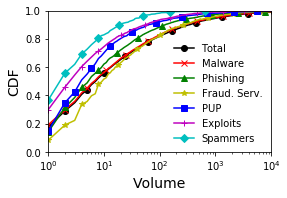

In [18]:
a = ip_attack_frame.drop('Totals',axis=1)
if 'Totals' in a:
    a.drop('Totals', axis=1,inplace=True)

a['Totals'] = a.transpose().sum()
a = a[a['Totals']>0]
final_df = a
    
plt.figure(figsize=(4,2.6))

for attk in ['Totals', 'Malware', 'Phishing', 'Fraudlent Services', 'Unwanted Programs', 
             'Exploits', 'Spammers']:
    a = final_df[attk][final_df[attk]!=0]
    linestyle = plot_properties_indexes[attk]['linestyle']
    color = plot_properties_indexes[attk]['color']
    label = plot_properties_indexes[attk]['label']
    marker = plot_properties_indexes[attk]['marker']
    
    cdf(a, color, linestyle, marker, label)

plt.ylabel("CDF",fontsize=14)
plt.xlabel("Volume",fontsize=14)

plt.xscale('log')
plt.xlim(1, 10000)
plt.ylim(0)
plt.legend(loc='lower right', frameon=False)

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

plt.savefig("./figures/asn_attack_cdf.pdf",bbox_inches='tight')
plt.show()

# Additional Analysis

In [20]:
# Top 10 ASs with total number of reports
final_df[['Totals','Malware','Phishing','Spammers','Unwanted Programs','Exploits','Fraudlent Services']].sort_values('Totals', ascending=False).head(10)

,Totals,Malware,Phishing,Spammers,Unwanted Programs,Exploits,Fraudlent Services
16509,25780070,24730443,463396,45,323347,20106,242733
20940,4540203,4083724,272612,0,152676,1076,30115
2914,2179430,2074612,87713,0,16533,406,166
35994,1666782,1567854,81695,0,15555,319,1359
209,1426533,1300545,114922,54,10032,518,462
3257,1138253,1045529,84834,0,7621,193,76
14618,1053876,824285,66336,107,104836,30114,28198
16276,1041795,980549,18289,104,4851,18366,19636
701,639313,613051,23407,0,2490,81,284
4134,625087,478846,141866,31,489,1427,2428


In [106]:
# Proportion of ASs with more than 1 reports
attk = 'Totals'
print('\n' + attk)
over_1 = len(final_df[final_df[attk] > 1])
total = len(final_df[final_df[attk] != 0])
print(over_1)
print(total)
print(1.0*over_1/total)

print "Mean reports per AS"
print(final_df[attk].mean())


Totals
10677
12950
0.824478764479
Mean reports per AS
3830.7596139


In [107]:
# Proportion of IPs with more than 5 reports
attk = 'Totals'
print('\n' + attk)
over_1 = len(final_df[final_df[attk] >= 5])
total = len(final_df[final_df[attk] != 0])
print(over_1)
print(total)
print(1.0*over_1/total)

print "Mean reports per AS"
print(final_df[attk].mean())


Totals
7671
12950
0.592355212355
Mean reports per AS
3830.7596139


In [108]:
# Proportion of ASs with more than one report
for attk in indexes:
    if attk == 'Unlabelled':
        continue
    print('\n' + attk)
    over_1 = len(final_df[final_df[attk] > 1])
    total = len(final_df[final_df[attk] != 0])
    print(over_1)
    print(total)
    print(1.0*over_1/total)
    print(final_df[final_df[attk] != 0][attk].mean())


Spammers
356
561
0.634581105169
13.3832442068

Malware
9248
11435
0.808745080892
3933.75461303

Exploits
2082
2966
0.701955495617
70.0967633176

Phishing
3785
4402
0.859836437983
551.740572467

Fraudlent Services
2995
3264
0.917585784314
345.682904412

Unwanted Programs
1877
2200
0.853181818182
387.894090909


In [112]:
# Proportion of ASs with over 10K reports
attk = 'Totals'
print('\n' + attk)
over_1 = len(final_df[final_df[attk] > 10000])
total = len(final_df[final_df[attk] != 0])
print(over_1)
print(total)
print(1.0*over_1/total)

print "Mean reports per AS"
print(final_df[attk].mean())

total_reports = sum(final_df[attk].values)

final_df[attk].sort_values(ascending=False).head(10)


Totals
141
12950
0.010888030888
Mean reports per AS
3830.7596139


16509    25780070
20940     4540203
2914      2179430
35994     1666782
209       1426533
3257      1138253
14618     1053876
16276     1041795
701        639313
4134       625087
Name: Totals, dtype: int64

In [113]:
# Investigate highest contributing AS
print(ip_attack_frame.loc[16509])

total_all = ip_attack_frame.drop('Totals', axis=1).sum().sum()
print(1.0*ip_attack_frame.loc[16509]['Totals'] / total_all)

Malware               24730443
Phishing                463396
Exploits                 20106
Fraudlent Services      242733
Unwanted Programs       323347
Spammers                    45
Unlabelled                   0
Totals                25780070
Name: 16509, dtype: int64
0.519672126885


In [114]:
# Investigate highest contributing AS of Virgin Islands
print(ip_attack_frame.loc[40034])

Malware               163803
Phishing                9144
Exploits               10200
Fraudlent Services     19941
Unwanted Programs       1168
Spammers                 642
Unlabelled                 0
Totals                204898
Name: 40034, dtype: int64


In [116]:
# Investigate AS
print(ip_attack_frame.loc[44571])

total_all = ip_attack_frame.drop('Totals', axis=1).sum().sum()
print(1.0*ip_attack_frame.loc[16509]['Totals'] / total_all)

Malware               2324
Phishing                54
Exploits                19
Fraudlent Services      11
Unwanted Programs        1
Spammers                 0
Unlabelled               0
Totals                2409
Name: 44571, dtype: int64
0.519672126885


In [117]:
# Check reports for AS 31624
ip_attack_frame.loc[31624]

Malware                9548
Phishing                459
Exploits                660
Fraudlent Services     1565
Unwanted Programs        15
Spammers                  6
Unlabelled                0
Totals                12253
Name: 31624, dtype: int64

In [118]:
# Report proportion of 10 ASs with the most reports
for attk in indexes:
    if attk == 'Unlabelled':
        continue
    print('\n' + attk)
    top_10_reports = final_df[attk].sort_values(ascending=False).head(10).sum()
    total_reports = sum(final_df[attk].values)
    print(top_10_reports)
    print(total_reports)
    print(1.0*top_10_reports/total_reports)


Spammers
3759
7508
0.500665956313

Malware
37699438
44982484
0.838091511354

Exploits
107506
207907
0.517086966769

Phishing
1550371
2428762
0.638337968068

Fraudlent Services
574529
1128309
0.509194733003

Unwanted Programs
719177
853367
0.842752297663


In [55]:
# Report proportion of 10 ASs with the most reports
attk = 'Totals'
print('\n' + attk)
top_10_reports = final_df[attk].sort_values(ascending=False).head(10).sum()
total_reports = sum(final_df[attk].values)
print(top_10_reports)
print(total_reports)
print(1.0*top_10_reports/total_reports)


Totals
40091342
49608337
0.808157346617


In [119]:
# Check uni of houston AS7276
final_df.loc[7276]

Malware               56711
Phishing               2744
Exploits                  7
Fraudlent Services        3
Unwanted Programs       320
Spammers                  0
Unlabelled                0
Totals                59785
Name: 7276, dtype: int64

In [120]:
# Average number of IPs in Spammer ASes
number = []
for asn, data in ip_in_asn['Spammers'].items():
    number.append(len(data))
print(np.mean(number))

3.991103202846975


In [121]:
# Average number of IPs in Phishing ASes
number = []
for asn, data in ip_in_asn['Phishing'].items():
    number.append(len(data))
print(np.mean(number))

30.56052691346809


In [122]:
# Number of ASes in Spammers
print(len(final_df[final_df['Spammers'] > 0]))
# Number of ASes in PUP
print(len(final_df[final_df['Unwanted Programs'] > 0]))


561
2200


In [123]:
# Proportion of unique malicious ASs 
for attk in indexes:
    if attk == 'Unlabelled':
        continue
    print('\n' + attk)
    mal_ASes = len(final_df[final_df[attk] > 0])
    total_ASes = len(final_df['Totals'])
    print(mal_ASes)
    print(total_ASes)
    print(100.0*mal_ASes/total_ASes)
    


Spammers
561
12950
4.33204633205

Malware
11435
12950
88.3011583012

Exploits
2966
12950
22.9034749035

Phishing
4402
12950
33.9922779923

Fraudlent Services
3264
12950
25.2046332046

Unwanted Programs
2200
12950
16.9884169884
